#Import speckle images

In [104]:
import tensorflow.keras.layers
import tensorflow.keras.models
import tensorflow.keras.optimizers
import tensorflow.keras.datasets
import numpy
import matplotlib.pyplot
from skimage.metrics import structural_similarity
from google.colab import files, drive
import cv2
import glob


drive.mount('/content/drive')
glob.glob("drive/My Drive/Paint_Tamiya/*.bmp")
path = "/content/drive/MyDrive/Paint_Tamiya/"

width = 100
height = 100
number_of_pixels = width*height
x_test_lst = []
x_train_lst = []

for i in range(1,1025):
  img_path = path + str(i) + ".bmp" 
  if i > 200 and i <= 400:
    x_test_lst.append(cv2.resize(cv2.imread(img_path, cv2.IMREAD_GRAYSCALE), (width, height)))
  x_train_lst.append(cv2.resize(cv2.imread(img_path, cv2.IMREAD_GRAYSCALE), (width, height)))

print(f'Size of test data: {len(x_test_lst)}')
print(f'Size of train data: {len(x_train_lst)}')

x_train_orig = numpy.array(x_train_lst)
x_test_orig = numpy.array(x_test_lst)
x_train_orig = x_train_orig.astype('float32') / 255.0
x_test_orig = x_test_orig.astype('float32') / 255.0

x_train = numpy.reshape(x_train_orig, newshape=(x_train_orig.shape[0], numpy.prod(x_train_orig.shape[1:])))
x_test = numpy.reshape(x_test_orig, newshape=(x_test_orig.shape[0], numpy.prod(x_test_orig.shape[1:])))
# randomly select input image
#index = numpy.random.randint(len(x_test))
# plot the image
#matplotlib.pyplot.imshow(x_test[index].reshape(width, height), cmap = "gray")


Mounted at /content/drive
Size of test data: 200
Size of train data: 1024


#Import data

In [84]:
import tensorflow 
import matplotlib.pyplot as plt
import numpy as np

from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Conv2DTranspose, Input, Reshape
from keras.datasets import mnist

fmnist = tf.keras.datasets.fashion_mnist
(x_train, _), (x_test, _) = fmnist.load_data()

# Normalize the pixel values
x_train_orig = x_train / 255.0
x_test_orig = x_test / 255.0

x_train = np.reshape(x_train, newshape=(x_train_orig.shape[0], np.prod(x_train_orig.shape[1:])))
x_test = np.reshape(x_test_orig, newshape=(x_test_orig.shape[0], np.prod(x_test_orig.shape[1:])))
x_test.shape




(10000, 784)

# Build model

In [85]:
# Encoder
x = tensorflow.keras.layers.Input(shape=(784), name="encoder_input")


encoder_dense_layer1 = tensorflow.keras.layers.Dense(units=300, name="encoder_dense_1")(x)
encoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="encoder_leakyrelu_1")(encoder_dense_layer1)

encoder_dense_layer2 = tensorflow.keras.layers.Dense(units=2, name="encoder_dense_2")(encoder_activ_layer1)
encoder_output = tensorflow.keras.layers.LeakyReLU(name="encoder_output")(encoder_dense_layer2)

encoder = tensorflow.keras.models.Model(x, encoder_output, name="encoder_model")
encoder.summary()

# Decoder
decoder_input = tensorflow.keras.layers.Input(shape=(2), name="decoder_input")

decoder_dense_layer1 = tensorflow.keras.layers.Dense(units=300, name="decoder_dense_1")(decoder_input)
decoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_1")(decoder_dense_layer1)

decoder_dense_layer2 = tensorflow.keras.layers.Dense(units=784, name="decoder_dense_2")(decoder_activ_layer1)
decoder_output = tensorflow.keras.layers.LeakyReLU(name="decoder_output")(decoder_dense_layer2)

decoder = tensorflow.keras.models.Model(decoder_input, decoder_output, name="decoder_model")
decoder.summary()

# Autoencoder
ae_input = tensorflow.keras.layers.Input(shape=(784), name="AE_input")
ae_encoder_output = encoder(ae_input)
ae_decoder_output = decoder(ae_encoder_output)

ae = tensorflow.keras.models.Model(ae_input, ae_decoder_output, name="AE")
ae.summary()




Model: "encoder_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 784)]             0         
                                                                 
 encoder_dense_1 (Dense)     (None, 300)               235500    
                                                                 
 encoder_leakyrelu_1 (LeakyR  (None, 300)              0         
 eLU)                                                            
                                                                 
 encoder_dense_2 (Dense)     (None, 2)                 602       
                                                                 
 encoder_output (LeakyReLU)  (None, 2)                 0         
                                                                 
Total params: 236,102
Trainable params: 236,102
Non-trainable params: 0
_______________________________________________

# Show images

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  app.launch_new_instance()


Image similarity 0.4310543411148501


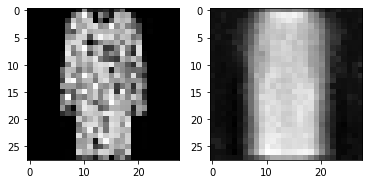

In [59]:
# RMSE
def rmse(y_true, y_predict):
    return tensorflow.keras.backend.mean(tensorflow.keras.backend.square(y_true-y_predict))

# AE Compilation
ae.compile(loss="mse", optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.0001), metrics = ['accuracy'])

# Training AE
history = ae.fit(x_train, x_train, epochs=10, batch_size=256, shuffle=True, validation_data=(x_test, x_test))

encoded_images = encoder.predict(x_test)
decoded_images = decoder.predict(encoded_images)
decoded_images_orig = np.reshape(decoded_images, newshape=(decoded_images.shape[0], 28, 28))

from skimage.metrics import structural_similarity
num_images_to_show = 1
#matplotlib.pyplot.figure()
for im_ind in range(num_images_to_show):
    plot_ind = im_ind*2 + 1
    rand_ind = np.random.randint(low=0, high=x_test_orig.shape[0])
    plt.subplot(num_images_to_show, 2, plot_ind)
    plt.imshow(x_test_orig[rand_ind, :, :], cmap="gray")
 
    plt.subplot(num_images_to_show, 2, plot_ind+1)
    plt.imshow(decoded_images_orig[rand_ind, :, :], cmap="gray")


# Calculate SSIM
rand_ind = np.random.randint(low=0, high=x_test_orig.shape[0])
(score, diff) = structural_similarity(x_test_orig[rand_ind, :, :], decoded_images_orig[rand_ind, :, :], full=True)
print("Image similarity", score)

#Plot loss and accuracy functions

In [ ]:
matplotlib.pyplot.figure(figsize=(10, 4))
ax =  matplotlib.pyplot.subplot(1, 2, 1)
matplotlib.pyplot.plot(history.history['accuracy'])
matplotlib.pyplot.plot(history.history['val_accuracy'])
matplotlib.pyplot.title('model accuracy')
matplotlib.pyplot.ylabel('accuracy')
matplotlib.pyplot.xlabel('epoch')
matplotlib.pyplot.legend(['train', 'val'], loc='upper left')
ax =  matplotlib.pyplot.gca()
ax.set_ylim([0, 0.5])


ax =  matplotlib.pyplot.subplot(1, 2, 2)
matplotlib.pyplot.plot(history.history['loss'])
matplotlib.pyplot.plot(history.history['val_loss'])
matplotlib.pyplot.title('model loss')
matplotlib.pyplot.ylabel('loss')
matplotlib.pyplot.xlabel('epoch')
matplotlib.pyplot.legend(['train', 'val'], loc='upper left')
ax =  matplotlib.pyplot.gca()
ax.set_ylim([0, 0.05])
matplotlib.pyplot.show()


#Save images to PC



In [110]:
from google.colab import files

files.download("/content/compressed.zip")
files.download("/content/original.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Save images to Colab

In [109]:
for i in range(1,201):
  matplotlib.pyplot.imsave('/content/compressed/'+ str(i)+ '.png', decoded_images_orig[i-1, :, :], cmap="gray") #compressed data
  matplotlib.pyplot.imsave('/content/original/'+ str(i)+ '.png', test_images_orig[i-1], cmap="gray") # original data

!zip -r /content/compressed.zip /content/compressed
!zip -r /content/original.zip /content/original


  adding: content/compressed/ (stored 0%)
  adding: content/compressed/69.png (deflated 10%)
  adding: content/compressed/25.png (deflated 10%)
  adding: content/compressed/139.png (deflated 10%)
  adding: content/compressed/80.png (deflated 11%)
  adding: content/compressed/97.png (deflated 10%)
  adding: content/compressed/104.png (deflated 10%)
  adding: content/compressed/77.png (deflated 11%)
  adding: content/compressed/50.png (deflated 11%)
  adding: content/compressed/127.png (deflated 11%)
  adding: content/compressed/78.png (deflated 11%)
  adding: content/compressed/174.png (deflated 11%)
  adding: content/compressed/156.png (deflated 10%)
  adding: content/compressed/84.png (deflated 11%)
  adding: content/compressed/141.png (deflated 11%)
  adding: content/compressed/71.png (deflated 11%)
  adding: content/compressed/63.png (deflated 10%)
  adding: content/compressed/184.png (deflated 11%)
  adding: content/compressed/194.png (deflated 11%)
  adding: content/compressed/112

#Clear folder with original images

In [ ]:
import os
!rm -rf /content/original/  
!rm -rf original.zip 
os.mkdir('/content/original/')
print('Original folder cleared')

Original folder cleared


#Clear folder with compressed images

In [ ]:
import os
!rm -rf /content/compressed/
!rm -rf compressed.zip 
os.mkdir('/content/compressed/')
print('Compressed folder cleared')

Compressed folder cleared


#Preparing MNIST dataset

In [ ]:

(x_train_orig, y_train), (x_test_orig, y_test) = tensorflow.keras.datasets.mnist.load_data()
x_train_orig = x_train_orig.astype("float32") / 255.0
x_test_orig = x_test_orig.astype("float32") / 255.0

x_train = numpy.reshape(x_train_orig, newshape=(x_train_orig.shape[0], numpy.prod(x_train_orig.shape[1:])))
x_test = numpy.reshape(x_test_orig, newshape=(x_test_orig.shape[0], numpy.prod(x_test_orig.shape[1:])))
print(f'Size of test data: {len(x_test)}')
print(f'Size of train data: {len(x_train)}')


# Fashion

In [86]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from keras import Sequential
from keras.layers import LeakyReLU 
from keras.datasets import mnist

fmnist = tf.keras.datasets.fashion_mnist
(training_images, _), (test_images, _) = fmnist.load_data()

# Normalize the pixel values
training_images_orig = training_images / 255.0
test_images_orig = test_images / 255.0

training_images = np.reshape(training_images_orig, newshape=(training_images_orig.shape[0], np.prod(training_images_orig.shape[1:])))
test_images = np.reshape(test_images_orig, newshape=(test_images_orig.shape[0], np.prod(test_images_orig.shape[1:])))
test_images.shape


(10000, 784)

# Model

In [105]:
number_of_pixels = width*height
test_images = x_test
training_images = x_train
test_images_orig = x_test_orig

model = Sequential([
    #encoder
    Input(shape=(number_of_pixels), name="encoder_input"),
    Dense(number_of_pixels, name = "encoder_dense_layer1"),
    #LeakyReLU(name="encoder_leakyrelu_1"),
    #Dense(100, name = "encoder_dense_layer2"),
    #LeakyReLU(name="encoder_leakyrelu_2"),
    #decoder
    Input(shape=(number_of_pixels), name="decoder_input"),
    #Dense(784, name = "decoder_dense_layer1"),
    #LeakyReLU(name="decoder_leakyrelu_1"),
    Dense(number_of_pixels, name = "decoder_dense_layer2"),
    #LeakyReLU(name="decoder_leakyrelu_2"),
  ])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mse', metrics = ['accuracy'])
model.summary()


Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_dense_layer1 (Dense  (None, 10000)            100010000 
 )                                                               
                                                                 
 decoder_input (InputLayer)  multiple                  0         
                                                                 
 decoder_dense_layer2 (Dense  (None, 10000)            100010000 
 )                                                               
                                                                 
Total params: 200,020,000
Trainable params: 200,020,000
Non-trainable params: 0
_________________________________________________________________


# Train model

Epoch 1/20
64/64 [==============================] - 77s 1s/step - loss: 0.0386 - accuracy: 0.0020 - val_loss: 0.0397 - val_accuracy: 0.0000e+00
Epoch 2/20
64/64 [==============================] - 81s 1s/step - loss: 0.0327 - accuracy: 0.0059 - val_loss: 0.0392 - val_accuracy: 0.0050
Epoch 3/20
64/64 [==============================] - 80s 1s/step - loss: 0.0287 - accuracy: 9.7656e-04 - val_loss: 0.0298 - val_accuracy: 0.0050
Epoch 4/20
64/64 [==============================] - 83s 1s/step - loss: 0.0249 - accuracy: 0.0029 - val_loss: 0.0263 - val_accuracy: 0.0100
Epoch 5/20
64/64 [==============================] - 77s 1s/step - loss: 0.0220 - accuracy: 0.0029 - val_loss: 0.0236 - val_accuracy: 0.0000e+00
Epoch 6/20
64/64 [==============================] - 81s 1s/step - loss: 0.0210 - accuracy: 0.0020 - val_loss: 0.0210 - val_accuracy: 0.0050
Epoch 7/20
64/64 [==============================] - 77s 1s/step - loss: 0.0193 - accuracy: 0.0029 - val_loss: 0.0188 - val_accuracy: 0.0100
Epoch 8/

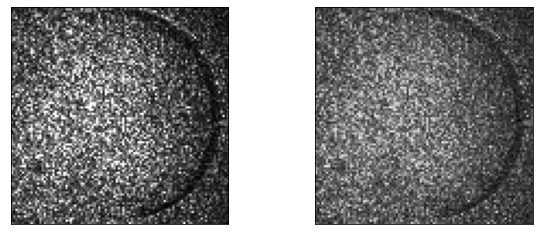

In [107]:
# train the model
model.fit(training_images, training_images, epochs=20, batch_size=16, validation_data=(test_images, test_images))


# predict the results from model (get compressed images)
decoded_images = model.predict(test_images)
decoded_images_orig = np.reshape(decoded_images, newshape=(decoded_images.shape[0], width, height))

index = np.random.randint(len(test_images_orig))
plt.figure(figsize=(10, 4))
# display original image
ax = plt.subplot(1, 2, 1)
plt.imshow(test_images_orig[index].reshape(width,height))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
# display compressed image
ax = plt.subplot(1, 2, 2)
plt.imshow(decoded_images_orig[index].reshape(width,height))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()